In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *
import emoji

# Visualization theme
USER_COLORS = ['#FFBDE6', '#AEE2FF']
COMBINED_COLOR = '#FFB534'
FONT_FAMILY = 'sans-serif'
BACKGROUND_COLOR = '#352F44'
GRID_COLOR = '#5C5470'
TEXT_COLOR = '#eee'

# Apply theme
set_seaborn_style(
    font_family= FONT_FAMILY,
    background_color=BACKGROUND_COLOR,
    grid_color = GRID_COLOR,
    text_color=TEXT_COLOR
)
sns.set_context(rc = {'patch.linewidth': 0.0})

# Load data
df = pd.read_csv('../data/cleaned_texts.csv')

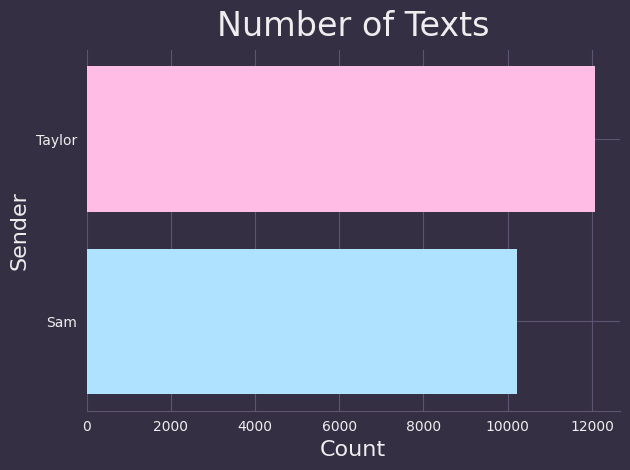

In [106]:
# Number of texts
text_counts = df['Sender'].value_counts()

# Plot
plt.barh(text_counts.index, text_counts.values, color=USER_COLORS)
plt.title('Number of Texts', fontsize=24, pad=10)
plt.xlabel('Count', fontsize=16)
plt.ylabel('Sender', fontsize=16)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [107]:
# Text Word Length Statistics
print('Number of Words per Text\n------------------------')
df.groupby('Sender')['num_words'].describe()

Number of Words per Text
------------------------


,count,mean,std,min,25%,50%,75%,max
Sender,,,,,,,,
Sam,10221.0,7.519616,6.825612,1.0,3.0,6.0,11.0,146.0
Taylor,12064.0,11.188909,13.352764,0.0,4.0,8.0,14.0,234.0


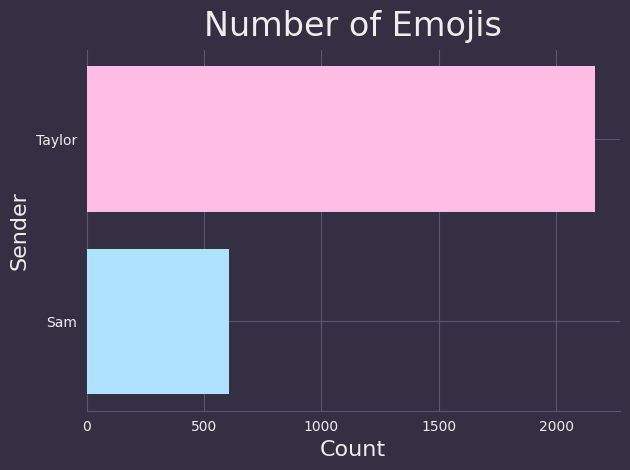

In [108]:
# Total Number of Emojis
total_emoji_counts = df.groupby('Sender')['emoji_num'].sum().reset_index()
total_emoji_counts = total_emoji_counts.sort_values(by='emoji_num', ascending=False)

plt.barh(total_emoji_counts['Sender'], total_emoji_counts['emoji_num'], color=USER_COLORS)
plt.title('Number of Emojis', fontsize=24, pad=10)
plt.xlabel('Count', fontsize=16)
plt.ylabel('Sender', fontsize=16)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [109]:
# List of all emojis
special_emojis = [':)', ':/', ':(', '◡̈']
emojis = special_emojis + [em['en'] for em in emoji.EMOJI_DATA.values()]

# Find emojis each used
emoji_counts = {}
for i, row in df.iterrows():
    sender = row['Sender']
    msg = row['Text']

    if not sender in emoji_counts.keys():
        emoji_counts[sender] = {}

    for em in emojis:
        count = str(msg).count(em)
        if (count > 0):
            if em in emoji_counts[sender].keys():
                emoji_counts[sender][em] += count
            else:
                emoji_counts[sender][em] = count

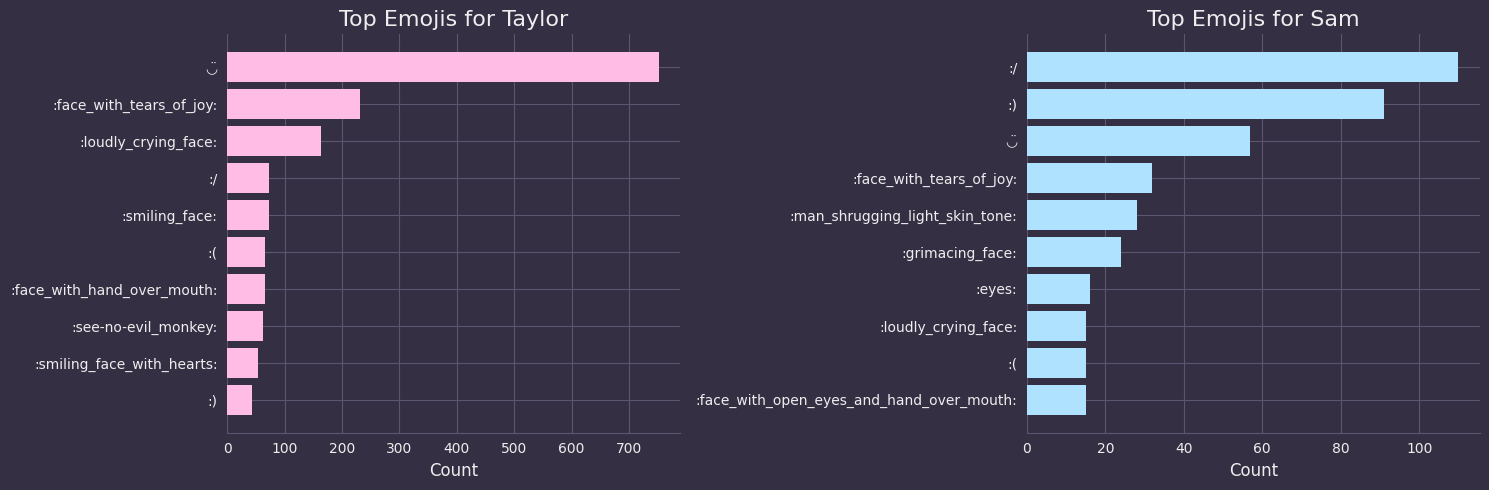

In [110]:
# Find top emojis
TOP_EMOJI_NUM = 10
top_emojis = {}
for sender in emoji_counts.keys():
    top_emojis[sender] = {}
for sender in emoji_counts.keys():
    top_emojis[sender] = dict(sorted(emoji_counts[sender].items(), key=lambda x: x[1], reverse=True)[:TOP_EMOJI_NUM])

# Plots
num_senders = len(top_emojis.keys())
fig, axs = plt.subplots(1, num_senders, figsize=(15, 5))
for i, sender in enumerate(top_emojis.keys()):
    ems = [em for em in top_emojis[sender].keys()]
    counts = list(top_emojis[sender].values())
    
    bars = axs[i].barh(ems, counts, color=USER_COLORS[i])
    axs[i].set_title('Top Emojis for {}'.format(sender), fontsize=16)
    axs[i].set_xlabel('Count', fontsize=12)
    axs[i].invert_yaxis()

plt.tight_layout()
plt.show()

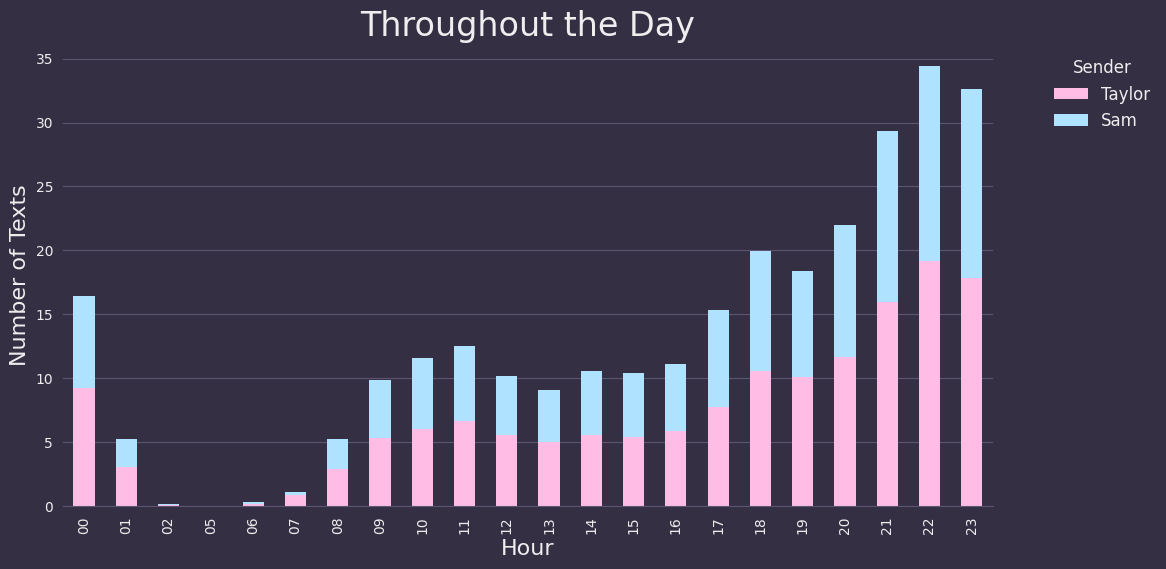

In [4]:
# Texts throughout the day
text_hours = {}
for i, row in df.iterrows():
    sender = row['Sender']
    hour = row['Date'][-5:-3]

    if not sender in text_hours.keys():
        text_hours[sender] = {}

    if not hour in text_hours[sender]:
        text_hours[sender][hour] = 1
    else:
        text_hours[sender][hour] += 1

# Calculate average number of texts at each hour
df_hours = pd.DataFrame(text_hours).fillna(0).sort_index()
first_date = df.iloc[0]['Date']
last_date = df.iloc[-1]['Date']
num_days = days_between_dates(first_date, last_date)
df_hours.iloc[:, 0:] = df_hours.iloc[:, 0:] / num_days

# Plot
df_hours.plot(kind='bar', stacked=True, color=USER_COLORS, figsize=(12,6))
plt.title('Throughout the Day', fontsize=24)
plt.xlabel('Hour', fontsize=16)
plt.ylabel('Number of Texts', fontsize=16)
plt.grid(axis='x', alpha=0)
plt.legend(title='Sender', bbox_to_anchor=(1.05, 1), loc='upper left', 
           fontsize=12, title_fontsize=12)
plt.show()